In [1]:
from tkinter import Scale

import numpy as np
import pandas as pd
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

from pyaw import utils
from pyaw.swarm import rotate_vector_by_quaternion

In [2]:
fps = ['./SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './aux_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './IGRF_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './SW_EXPT_EFIA_TCT16_12885_20160311T061733_20160311T075106.pkl']

In [3]:
df_b = pd.read_pickle(fps[0])
df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

In [4]:
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius','q_NEC_CRF']]
df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]

In [5]:
st = '20160311T064000'
et = '20160311T065000'
df_b_clip = df_b_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_e_clip = df_e_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

np.all(np.equal(df_b_clip.index.values,df_b_IGRF_clip.index.values))

True

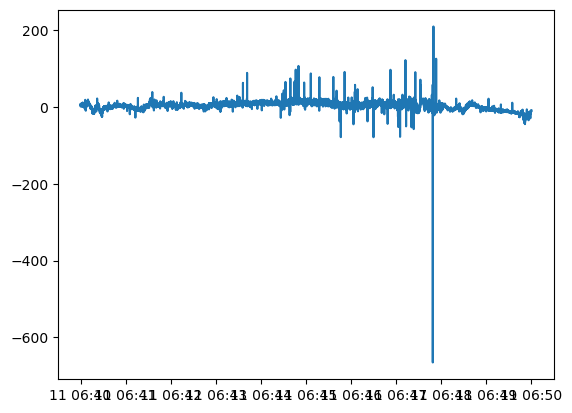

In [6]:
ehx = df_e_clip['Ehx'].values

plt.plot(df_e_clip.index.values, ehx)
plt.show()

In [7]:
ehx = utils.set_outliers_nan_std(ehx,1,print_=False)
ehx = utils.get_array_interpolated(df_e_clip.index.values,ehx)

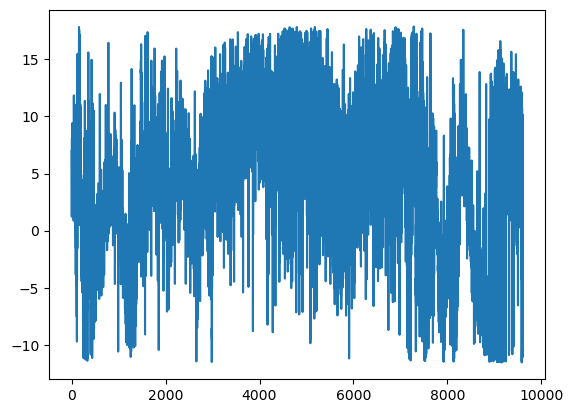

In [8]:
plt.plot(ehx)
plt.show()

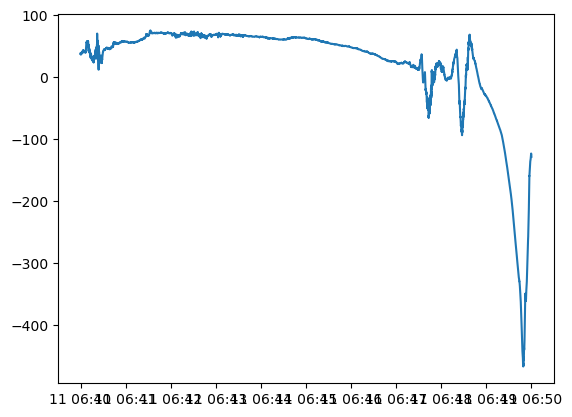

In [9]:
b_sc = []  # b in S/C
b_igrf_sc = []  # igrf b in S/C
for b_nec,b_nec_igrf,q_NEC_CRF in zip(df_b_clip['B_NEC'].values,df_b_IGRF_clip['B_NEC_IGRF'].values,df_b_clip['q_NEC_CRF'].values):
    q_CRF_NEC = np.array([-q_NEC_CRF[0],-q_NEC_CRF[1],-q_NEC_CRF[2],q_NEC_CRF[3]])
    b_sc.append(rotate_vector_by_quaternion(b_nec, q_CRF_NEC))
    b_igrf_sc.append(rotate_vector_by_quaternion(b_nec_igrf, q_CRF_NEC))
b_sc = np.array(b_sc)
b_igrf_sc = np.array(b_igrf_sc)

by1 = b_sc[:,1] - b_igrf_sc[:,1]

plt.plot(df_b_clip.index.values, by1)

In [10]:
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values

by1 = utils.align_high2low(by1, datetimes_b, datetimes_e)

In [11]:
fs = 16
window = 'hann'
stft_window_seconds = 4
nperseg = int(stft_window_seconds * fs)
noverlap = nperseg // 2

freqs, ts, Sxx_e = spectrogram(ehx, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')
_, _, Sxx_b = spectrogram(by1, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, mode='complex')

ts_dt64 = datetimes_e[0] + [np.timedelta64(int(_), 's') for _ in ts]

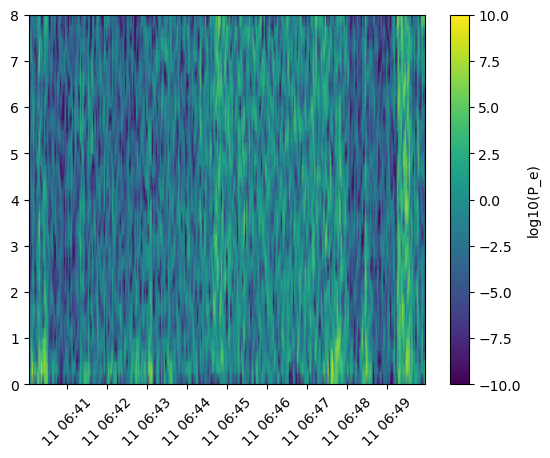

In [12]:
Sxx_e_m = np.abs(Sxx_e)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(Sxx_e_m), shading='gouraud', vmin=-10, vmax=10)  # 可以用初始值也可以用log10
plt.colorbar(label='log10(P_e)')  # psd
plt.xticks(rotation=45)
plt.show()

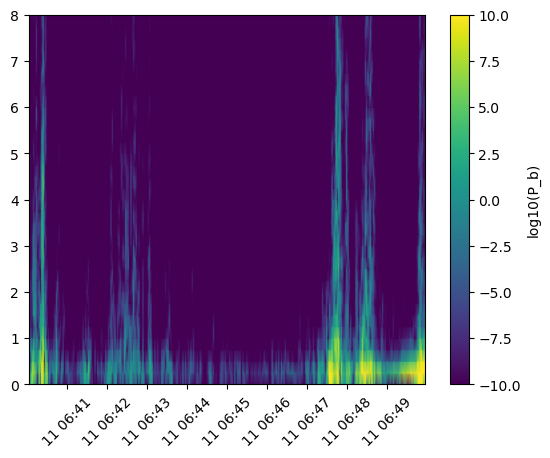

In [13]:
Sxx_b_m = np.abs(Sxx_b)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(Sxx_b_m), shading='gouraud', vmin=-10, vmax=10)
plt.colorbar(label='log10(P_b)')
plt.ylim([0, 8])
plt.xticks(rotation=45)
plt.show()

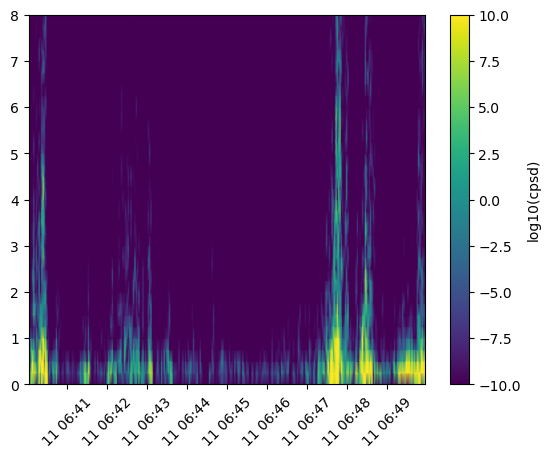

In [14]:
cpsd = Sxx_e * np.conj(Sxx_b)

cpsd_m = np.abs(cpsd)
plt.pcolormesh(ts_dt64, freqs, 10 * np.log10(cpsd_m), shading='gouraud', vmin=-10, vmax=10)
plt.xticks(rotation=45)
plt.colorbar(label='log10(cpsd)')
plt.show()

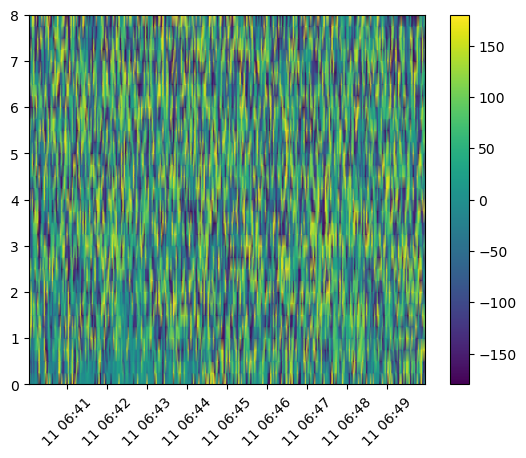

In [15]:
# phase
cpsd_p = np.degrees(np.angle(cpsd))
plt.pcolormesh(ts_dt64, freqs, cpsd_p, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()  # 交叉谱中很多由于数据本身的噪声的影响，导致相位图像没有规律?

In [16]:
np.max(cpsd_m),np.min(cpsd_m),np.percentile(cpsd_m, 50)

(103.86020605611601, 2.4361152254424467e-06, 0.014459608151262985)

In [17]:
cpsd_p_mask = cpsd_p.copy()
cpsd_p_mask[cpsd_m < 0.003] = np.nan

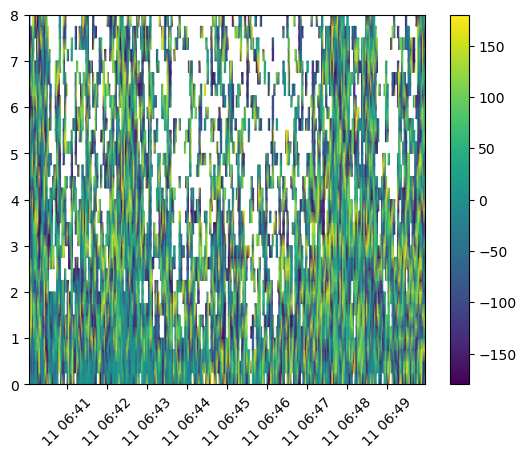

In [18]:
plt.pcolormesh(ts_dt64, freqs, cpsd_p_mask, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [19]:
num_bins = 50
phase_bins, phase_histogram2d = utils.get_phase_histogram2d(freqs,cpsd_p_mask,num_bins=num_bins)

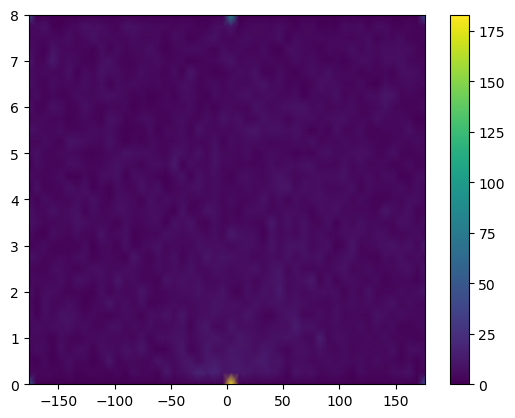

In [20]:
plt.pcolormesh((phase_bins[:-1] + phase_bins[1:]) / 2, freqs, phase_histogram2d, shading='gouraud')
plt.colorbar()
plt.show()

In [21]:
# 相位平均值
phases = []
for i in range(len(phase_bins)-1):
    phases.append((phase_bins[i+1]+phase_bins[i])/2)

phases_ave = []
for histogram in phase_histogram2d:
    phases_ave.append(np.sum(histogram * phases)/np.sum(histogram))  # todo:: 分母为0的情况
phases_ave = np.array(phases_ave)

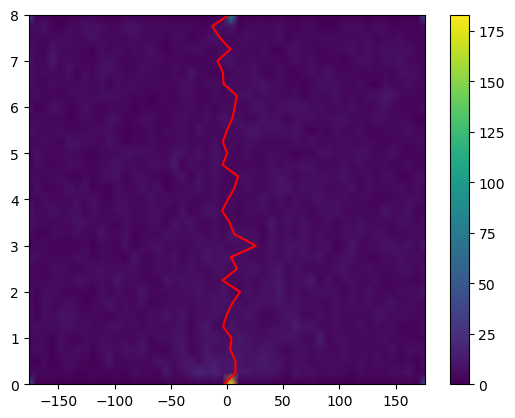

In [22]:
plt.pcolormesh((phase_bins[:-1] + phase_bins[1:]) / 2, freqs, phase_histogram2d, shading='gouraud')
plt.plot(phases_ave,freqs,color='r')
plt.colorbar()
plt.show()  # todo:: 10 min 也是在0处振荡？计算平均相位的方法对了吗？用wu的static时间测试一下？

In [15]:
step=11
coherences = utils.get_coherences(Sxx_e, Sxx_b, cpsd, step=step)

In [16]:
ts_dt64_split = utils.split_array(ts_dt64,step=step)

def get_middle_element(lst):
    n = len(lst)
    if n == 0:
        return None  # Handle the case of an empty list
    mid = n // 2
    if n % 2 == 0:  # Even number of elements
        return lst[mid - 1]  # Return the former one of the two middle elements
    else:  # Odd number of elements
        return lst[mid]  # Return the single middle element


dts_cohe = [get_middle_element(i) for i in ts_dt64_split]

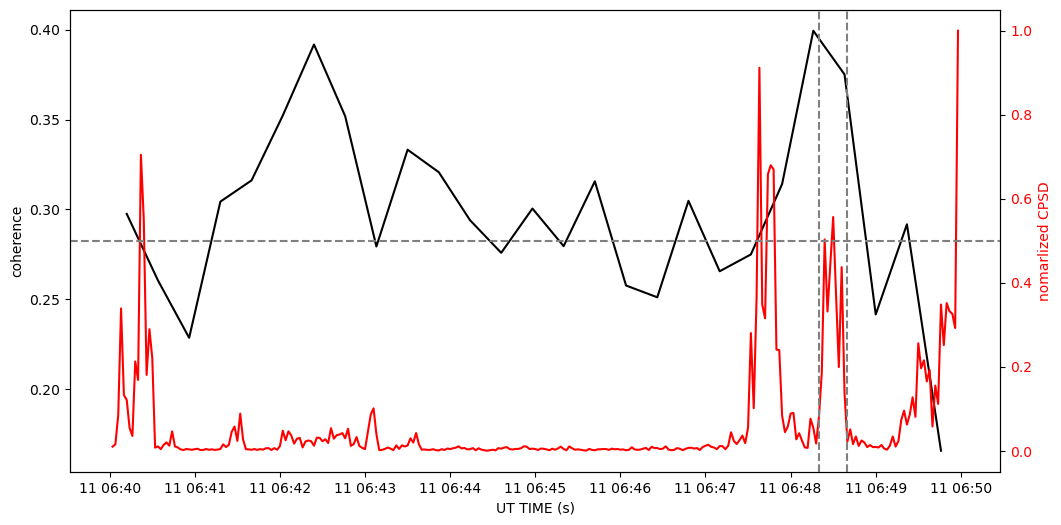

In [17]:
# Create a figure and the first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first dataset
ax1.plot(dts_cohe, coherences, color='black')
ax1.set_xlabel('UT TIME (s)')
ax1.set_ylabel('coherence', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis with its own x-axis
ax2 = ax1.twinx()  # Share the same x-axis
ax2.plot(ts_dt64, utils.normalize_to_01(cpsd_m.mean(axis=0)), color='red')
ax2.set_ylabel('nomarlized CPSD', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.axhline(0.5,color='gray',linestyle='--')

import matplotlib.dates as mdates

plt.axvline(mdates.date2num(np.datetime64('2016-03-11T06:48:20')),color='gray',linestyle='--')
plt.axvline(mdates.date2num(np.datetime64('2016-03-11T06:48:40')),color='gray',linestyle='--')
plt.xticks(rotation=45)
plt.show()  # todo:: coherences 用其它方法？

# dynamic: 06:48:20-06:48:40

In [27]:
st_dy = np.datetime64('2016-03-11T06:48:20')
et_dy = np.datetime64('2016-03-11T06:48:40')
t_mask = (datetimes_e >= st_dy) & (datetimes_e <= et_dy)
datetimes_dy = datetimes_e[t_mask]
ehx_dy = ehx[t_mask]
by1_dy = by1[t_mask]

In [46]:
# ehx by1
ehx_dy_fft = utils.FFT(ehx_dy,fs)
by1_dy_fft = utils.FFT(by1_dy,fs)

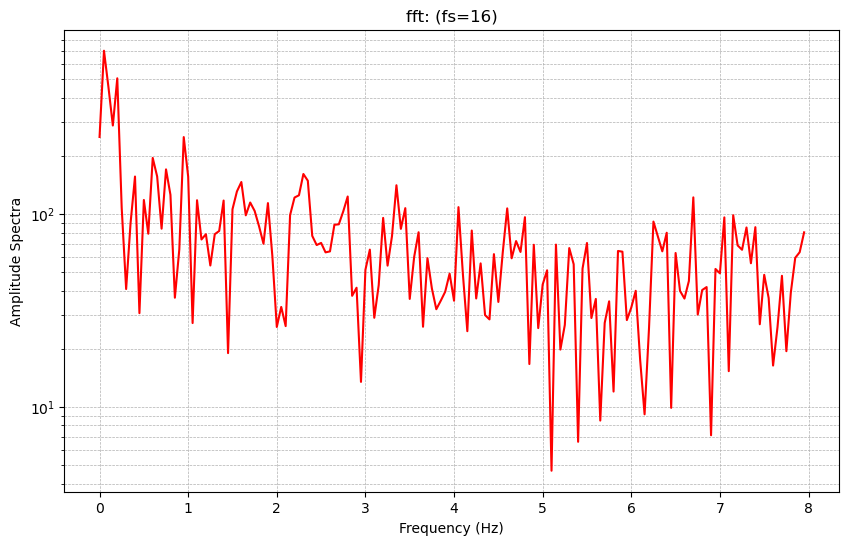

In [47]:
ehx_dy_fft.plot_fft()
plt.show()

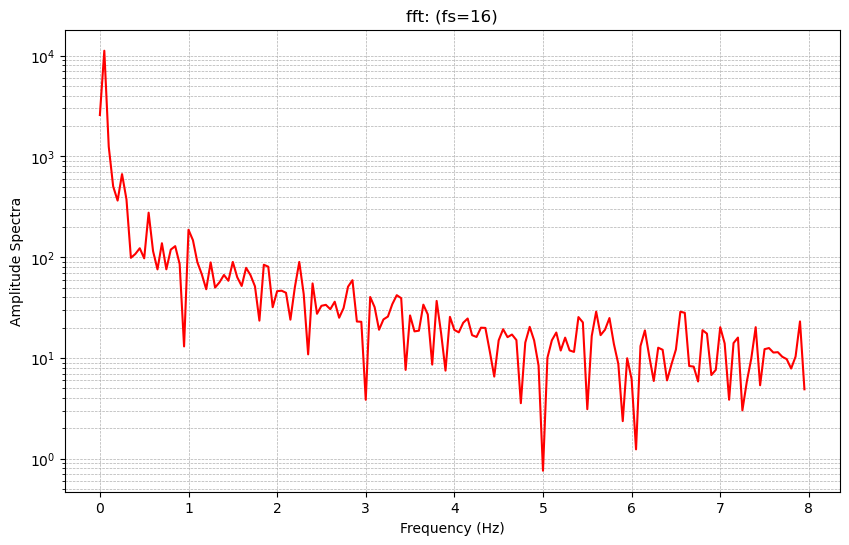

In [48]:
by1_dy_fft.plot_fft()
plt.show()

In [49]:
freqs_dy, amp_e_dy, _ = ehx_dy_fft.get_fft()
_, amp_b_dy, _ = by1_dy_fft.get_fft()

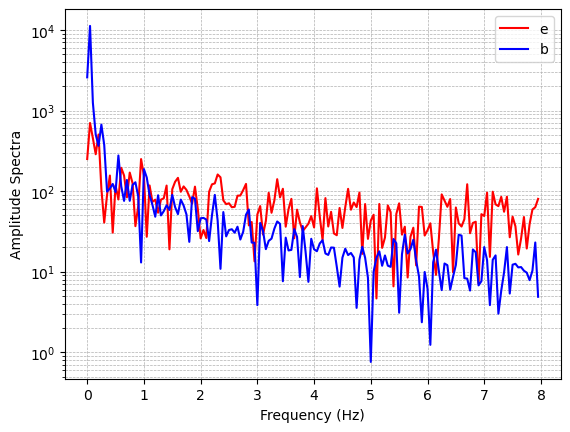

In [50]:
plt.plot(freqs_dy, amp_e_dy, color='red', label='e')
plt.plot(freqs_dy, amp_b_dy, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()
# 当ehx没有处理异常值时，得到的fft和论文区别很大，处理异常之后，2者近似。
# iaw，iar那篇论文用的是什么分量？ https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2003JA010329 Akebono satellite ey,bz and ez,by
# 看到的现象只是噪声的结果？

In [51]:
eb_ratio_fft_dy = amp_e_dy / amp_b_dy
eb_ratio_fft_dy = eb_ratio_fft_dy * 1e-3 * 1e9

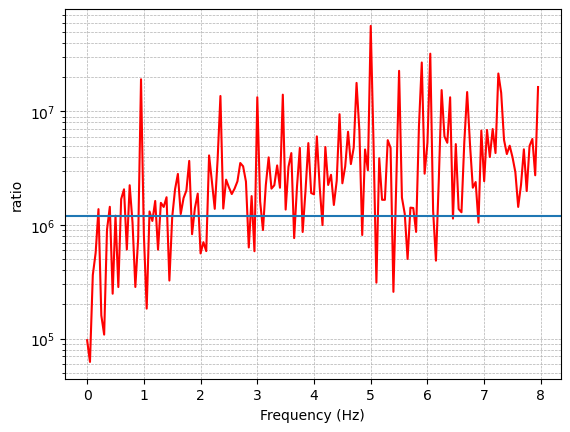

In [52]:
plt.plot(freqs_dy, eb_ratio_fft_dy, color='red', label='e')
plt.axhline(1.2e6)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()  # todo:: 上下边界

In [28]:
# phase

freqs_dy, ts_dy, Zxx_e_dy = spectrogram(ehx_dy, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')
_, _, Zxx_b_dy = spectrogram(by1_dy, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')

ts_dt64_dy = datetimes_dy[0] + [np.timedelta64(int(_), 's') for _ in ts_dy]

cpsd_dy = Zxx_e_dy * np.conj(Zxx_b_dy)

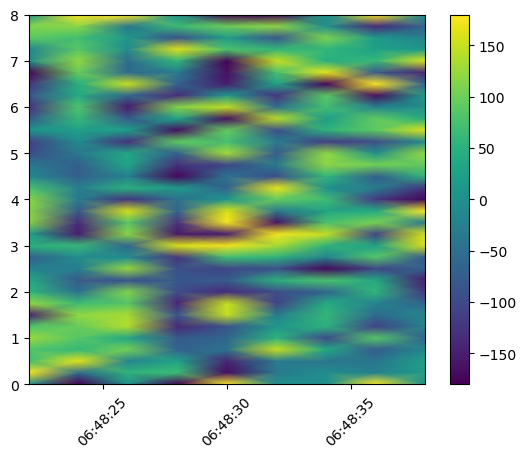

In [29]:
# phase
cpsd_phase_dy = np.degrees(np.angle(cpsd_dy))
plt.pcolormesh(ts_dt64_dy, freqs_dy, cpsd_phase_dy, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [36]:
cpsd_phase_dy_mask = cpsd_phase_dy.copy()
cpsd_m_dy = np.abs(cpsd_dy)
cpsd_phase_dy_mask[cpsd_m_dy < 0.03] = np.nan

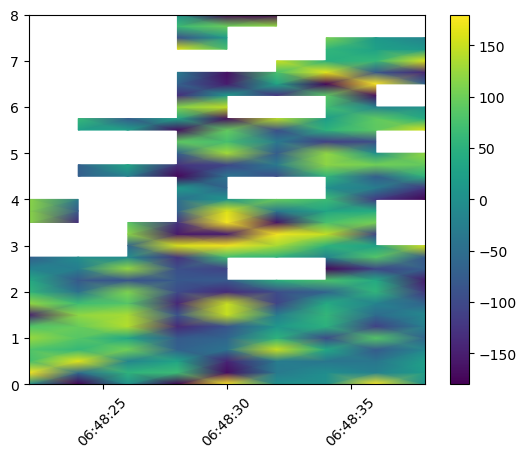

In [37]:
plt.pcolormesh(ts_dt64_dy, freqs_dy, cpsd_phase_dy_mask, shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

In [38]:
num_bins = 50
phase_bins, phase_histogram2d = utils.get_phase_histogram2d(freqs_dy,cpsd_phase_dy_mask,num_bins=num_bins)

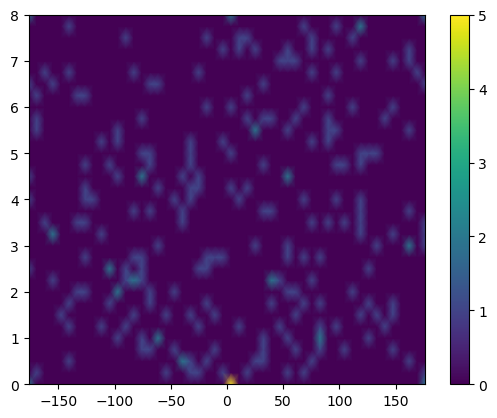

In [39]:
plt.pcolormesh((phase_bins[:-1] + phase_bins[1:]) / 2, freqs_dy, phase_histogram2d, shading='gouraud')
plt.colorbar()
plt.show()

In [ ]:
# 相位平均值

In [43]:
phases = []
for i in range(len(phase_bins)-1):
    phases.append((phase_bins[i+1]+phase_bins[i])/2)

In [45]:
phases_ave = []
for histogram in phase_histogram2d:
    phases_ave.append(np.sum(histogram * phases)/np.sum(histogram))
phases_ave = np.array(phases_ave)

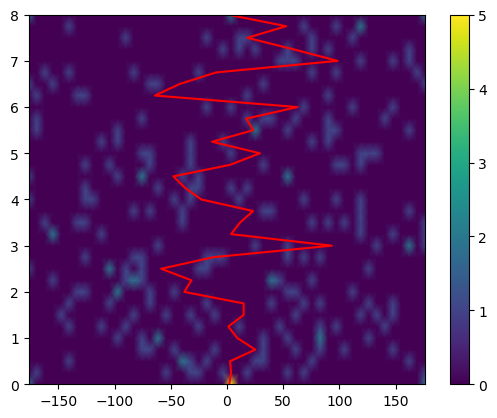

In [47]:
plt.pcolormesh((phase_bins[:-1] + phase_bins[1:]) / 2, freqs_dy, phase_histogram2d, shading='gouraud')
plt.plot(phases_ave,freqs_dy,color='r')
plt.colorbar()
plt.show()